# Boundary mapping

The purpose of this notebook is to mess around with all the different options available with boundary mapping

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import database
from testing_framework import testing_utils
from preprocessing import preprocessing_utils, merge_search
from identification import create_hits
import operator
import collections


#Assumptions:
max_peptide_length = 23
ppm_tolerance = 20
peak_filter = 25
relative_abundance_filter = 0.1

import matplotlib.pyplot as plt

In [2]:
datasets = testing_utils.define_data()

dataset = datasets[0]

input_spectra_path = [os.path.join(dataset[0], 'NOD2_E3.mzML')]
input_spectra, boundaries = preprocessing_utils.load_spectra(input_spectra_path, ppm_tolerance, peak_filter=peak_filter, relative_abundance_filter=relative_abundance_filter)

correct_sequences = testing_utils.generate_truth_set(datasets[0])

path = dataset[2]
db = database.build(path)

In [4]:
write_path = os.path.abspath(os.path.join(module_path, 'intermediate_files'))
matched_masses_b, matched_masses_y, kmer_set = merge_search.modified_match_masses(boundaries, db, max_peptide_length, True, write_path)
print('Finished matching masses')

On protein 279/279 [100%]
Sorting the set of protein masses...
Sorting the set of protein masses done
Performing Merge
Done
Finished matching masses


# Grabbing hits

In [ ]:
spectrum_num = 100
correct_sequence = correct_sequences[spectrum_num]
print(correct_sequence)

input_spectrum = input_spectra[spectrum_num]

#Remember to add in abundance if it is helpful
location = os.path.join(module_path, 'intermediate_files')
b_hits, y_hits = create_hits(spectrum_num, input_spectrum, matched_masses_b, matched_masses_y, False, location)
correct_hits = testing_utils.append_correct_hits(correct_sequence, input_spectrum, ppm_tolerance)

In [ ]:
print(input_spectrum.mz_values)

# Scoring hits

In [ ]:
from utils import hashable_boundaries

def get_unique_matched_masses(boundaries, matched_masses_b, matched_masses_y):
    unique_b,unique_y = dict(), dict()
    for mz in boundaries.keys():
        unique_b[mz],unique_y[mz] = [],[]
        for x in matched_masses_b[mz]:
            seq = x[2]
            charge = x[5]
            if seq not in unique_b[mz]:
                unique_b[mz].append(seq)
        for x in matched_masses_y[mz]:
            seq = x[2]
            charge = x[5]
            if seq not in unique_y[mz]:
                unique_y[mz].append(seq)
    return unique_b, unique_y

unique_b,unique_y = get_unique_matched_masses(boundaries, matched_masses_b, matched_masses_y)

# Clustering b hits

In [ ]:
def write_cluster(cluster):
    if len(cluster) == 0 : return None
    O = []
    O.append(len(cluster))
    O.append(cluster[0].pid)
    max_len = 0
    max_hit = None
    for hit in cluster:
        l = hit.end - hit.start + 1
        if l > max_len:
            max_len = l
            max_hit = hit
    O.append(max_hit.seq)
    O.append(max_hit.mz)
    O.append(max_hit.start)
    O.append(max_hit.end)
    for hit in cluster:
        O.append( (hit.start, hit.end, hit.seq, hit.mz) ) 
    return O
def parse_hits(Hit, all_hits):
    hits = []
    for A in all_hits:
        pid = int(A[2][1])
        start = int(A[2][3].split('-')[0])
        end = int(A[2][3].split('-')[1])
        seq = A[2][2]
        mz = A[1]

        hits.append( Hit(pid=pid, start=start, end=end, seq=seq, mz=mz) )
    return hits

def create_clusters(ion, b_hits, y_hits):
    clusters = []
    Hit = collections.namedtuple('Hit', 'pid start end seq mz')
    if ion == 'b':
        hits = parse_hits(Hit, b_hits)
        sorted_hits = sorted(hits, key=operator.attrgetter('pid', 'start', 'end'))
        last_pid = None
        last_start = None
        cluster = []
        if ion == 'b':
            for hit in sorted_hits:
                if last_pid == hit.pid and last_start == hit.start:
                    cluster.append(hit)
                else:
                    if cluster != []:
                        clusters.append(write_cluster(cluster))
                    cluster = [hit]
                last_pid = hit.pid
                last_start = hit.start
    else:
        hits = parse_hits(Hit, y_hits)
        sorted_hits = sorted(hits, key=operator.attrgetter('pid', 'end', 'start'))
        last_pid = None
        last_start = None
        cluster = []
        if ion == 'y':
            for hit in sorted_hits:
                if last_pid == hit.pid and last_end == hit.end:
                    cluster.append(hit)
                else:
                    if cluster != []:
                        clusters.append(write_cluster(cluster))
                    cluster = [hit]
                last_pid = hit.pid
                last_end = hit.end
    return clusters

In [ ]:
import utils

def calc_mass_given_other_explanations(unique_m, seq, mz):
    oEXPnum = (len(unique_m[mz]) - 1)/ len(unique_m[mz])
    if oEXPnum == 0:
        return 0
    else:
        p = 0
        for i, seq2 in enumerate(unique_m[mz]):
            if seq == seq2:
                continue
            else:
                p = p + 1/len(seq2)
        return p

def Bayes_given_mass(pH, seq, mz, unique_m):
    pEH = 1/len(seq)
    pnH = 1-pH
    pEnH = calc_mass_given_other_explanations(unique_m, seq, mz)
    prob = (pH * pEH)/((pH*pEH)+(pnH*pEnH))
#     print(seq,pH,pEH,(pH*pEH),(pnH*pEnH),pnH,pEnH)
    return prob

def Bayes(seq, mz, unique_m, indices, kmer_set):
    pH = len(seq)/len(kmer_set)
    for index in reversed(indices):
        prob = Bayes_given_mass(pH, seq, mz, unique_m)
        pH = prob
    return prob

def parse_indices(index_set):
    indices = []
    for index in index_set:
        string = str(index)
        A = string.rstrip().split(',')
        start = A[0]
        end = A[1]
        seq = A[2]
        mz = A[3]
        disallowed_characters = " ()\'"
        for character in disallowed_characters:
            start = start.replace(character, "")
            end = end.replace(character, "")
            seq = seq.replace(character, "")
            mz = mz.replace(character, "")
        
        target_tuple = (int(start), int(end), seq, float(mz))
        indices.append(target_tuple)
    
    
    return indices

def Bayes_clusters(ion, clusters, path, unique_b, unique_y, kmer_set):
    cluster = collections.namedtuple('cluster', 'prob score pid start end seq mz indices')
    if ion == 'b':
        b_cluster_array = []
        for A in clusters:
            score = A[0]
            pid = int(A[1])
            seq = A[2]
            mz = float(A[3])
            start = int(A[4])
            end = int(A[5])
            indices = A[6:]
            prob = Bayes(seq, mz, unique_b, indices, kmer_set)
            target_cluster = cluster(prob=prob, score=score, pid=pid, start=start, end=end, seq=seq, mz=mz, indices=indices)

            b_cluster_array.append(target_cluster)

        b_sorted_clusters = sorted(b_cluster_array, key=operator.attrgetter('score', 'pid'), reverse = True)
        return b_sorted_clusters
    else:
        y_cluster_array = []
        for A in clusters:
            score = A[0]
            pid = int(A[1])
            seq = A[2]
            mz = float(A[3])
            start = int(A[4])
            end = int(A[5])
            indices = A[6:]
            prob = Bayes(seq, mz, unique_y, indices, kmer_set)
            target_cluster = cluster(prob=prob, score=score, pid=pid, start=start, end=end, seq=seq, mz=mz, indices=indices)
            y_cluster_array.append(target_cluster)

        y_sorted_clusters = sorted(y_cluster_array, key=operator.attrgetter('score', 'pid'), reverse = True)
        return y_sorted_clusters

In [ ]:
ion = 'b'
path = os.path.join(os.path.abspath(os.path.join('../..')), 'intermediate_files/')
clusters = create_clusters(ion, b_hits, y_hits)
print(clusters[0])
b_sorted_clusters = Bayes_clusters(ion, clusters, path, unique_b, unique_y, kmer_set)

# Printing data

In [ ]:
# b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('score', 'prob', 'pid'), reverse = True)
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('prob', 'score', 'pid'))
testing_utils.write_b_sorted_cluster(b_sorted_clusters)
for i in range(0,50):
    x = b_sorted_clusters[i]
    post_prob = x.prob
    score = x.score
    seq = x.seq
    indices = x.indices
    print(post_prob, score, seq)

# Clustering y_hits

In [57]:
ion = 'y'
path = os.path.join(os.path.abspath(os.path.join('../..')), 'intermediate_files/')
clusters = create_clusters(ion, b_hits, y_hits)
y_sorted_clusters = Bayes_clusters(ion, clusters, path, kmer_set)

# Printing data

In [77]:
# y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('score', 'prob', 'pid'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('prob', 'score', 'pid'))
for i in range(0, 50):
    x = y_sorted_clusters[i]
    post_prob = x.prob
    score = x.score
    seq = x.seq
    indices = x.indices
    print(post_prob, score, seq)

6.251216361254701e-18 5 VQSSRSGRGGNFGFG
7.93187399385487e-18 5 EQIKEYFG
3.7744989088666756e-17 4 TNHFLVELHKDG
9.212250774596327e-16 4 NVGAGGPAPAAGAAPAGGAAPS
1.124874206212982e-15 4 PGFGAPAASQVASAQPG
1.3006481413536612e-14 3 NIGEQGHMALLG
1.3737665244739614e-14 3 VAAAASVPAQSTARTG
1.53786417388688e-14 3 AVPAASYGRIYAGGG
1.5634100899348267e-14 3 ALANVNIGSLICNVG
1.5634100899348267e-14 3 GLTSLTEPPKGPGFG
1.7952154651857537e-14 3 RAHYITVIAKDGGG
1.7952154651857544e-14 3 PEKVTPVAAVQDGF
2.2736368109813266e-14 3 DHGVQGPVAGTGDFG
2.6627539105973593e-14 3 QVAQFLKAAEDYG
3.522508843246268e-14 3 ARTKCQEVVGTFG
3.522508843246268e-14 3 RILENPQGLSDPG
4.135847291853432e-14 3 VIVFDTDNRIFG
5.526307802019468e-14 3 LLDEGHYPVRESP
5.541605281949941e-14 3 VMSDPNRPPCRKN
5.5575772511336463e-14 3 NVAVALQFGAEIGNYSCAAAG
5.795815072607436e-14 3 PESYFSPGKAFEG
6.128808359836822e-14 3 GGRGGARGRGRGQGQNWNQG
6.506968632377694e-14 3 QFHFKDFNRAFG
6.792858752491663e-14 3 YGYTHLSTGDLLRAEVSSG
6.792858752491663e-14 3 VCKCFCRSKGHGFITP

# Plotting

In [59]:
from scoring import mass_comparisons
import gen_spectra
print("Collecting data...")
score_array = []
posterior_array = []
bscore_array = []
for cluster in b_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='b')))
    posterior_array.append(cluster.prob)
    bscore_array.append(cluster.score)
for cluster in y_sorted_clusters:
    score_array.append(mass_comparisons.optimized_compare_masses(input_spectrum.mz_values, gen_spectra.gen_spectrum(cluster.seq, ion='y')))
    posterior_array.append(cluster.prob)
    bscore_array.append(cluster.score)
print("Done")


Done


Text(0.5, 1.0, 'Posterior probability vs Simple additive scoring')

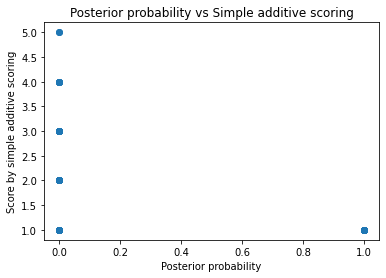

In [60]:
plt.scatter(posterior_array, score_array, s=None)
plt.ylabel('Score by simple additive scoring')
plt.xlabel('Posterior probability')
plt.title("Posterior probability vs Simple additive scoring")

Text(0.5, 1.0, 'Posterior probability vs cluster scoring')

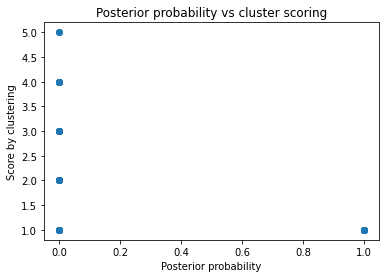

In [61]:
plt.scatter(posterior_array, bscore_array, s=None)
plt.xlabel("Posterior probability")
plt.ylabel("Score by clustering")
plt.title("Posterior probability vs cluster scoring")

# Probability of true positives

In [62]:
def calc_average(list):
    total = 0
    for x in list:
        total = total + x
    return total / len(list)

In [63]:
for cluster in b_sorted_clusters:
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Yay')
# for cluster in y_sorted_clusters:
#     assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
#     if assessment == True:
#         print('Yay')

In [64]:
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('prob', 'score', 'pid'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('prob', 'score', 'pid'), reverse = True)


b_post_prob_array = []
b_score_array = []
y_post_prob_array = []
y_score_array = []
bad_clusters_prob = []
bad_clusters_score = []
ion = 'b'
for cluster in b_sorted_clusters:
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_post_prob_array.append(cluster.prob)
        b_score_array.append(cluster.score)
    else:
        bad_clusters_prob.append(cluster.prob)
        bad_clusters_score.append(cluster.score)
ion = 'y'
for cluster in y_sorted_clusters:
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_post_prob_array.append(cluster.prob)
        y_score_array.append(cluster.score)
    else:
        bad_clusters_prob.append(cluster.prob)
        bad_clusters_score.append(cluster.score)   

b_range = []
y_range = []
for i, x in enumerate(b_post_prob_array):
    b_range.append(i)
for i, x in enumerate(y_post_prob_array):
    y_range.append(i)
print('Average probability of b true positives in first spectrum:' ,calc_average(b_post_prob_array))
print('Average count of b true positives in first spectrum:' ,calc_average(b_score_array))
print('Average probability of y true positives in first spectrum:' ,calc_average(y_post_prob_array))
print('Average count of y true positives in first spectrum:' ,calc_average(y_score_array))
print('Average probability of false positives in the first spectrum:', calc_average(bad_clusters_prob))
print('Average count of false positives in the first spectrum:', calc_average(bad_clusters_score))
print('Number of true b positives', len(b_range))
print('Number of true y positives', len(y_range))
print('Number of bad clusters', len(bad_clusters_prob))

Average probability of b true positives in first spectrum: 9.133419527453328e-09
Average count of b true positives in first spectrum: 1.0
Average probability of y true positives in first spectrum: 0.964401820621643
Average count of y true positives in first spectrum: 1.0360858257477243
Average probability of false positives in the first spectrum: 7.425941806848212e-05
Average count of false positives in the first spectrum: 1.1115293770298198
Number of true b positives 1
Number of true y positives 6152
Number of bad clusters 27096


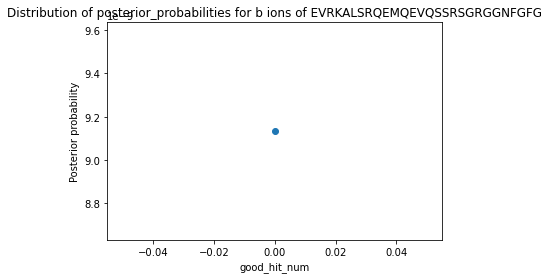

In [65]:
fig1, ax1 = plt.subplots()
ax1.scatter(x = b_range, y = b_post_prob_array)
plt.title("Distribution of posterior_probabilities for b ions of " + correct_sequence)
plt.xlabel("good_hit_num")
plt.ylabel("Posterior probability")
plt.show()

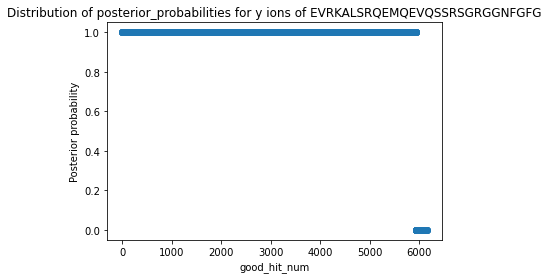

In [66]:
fig1, ax1 = plt.subplots()
ax1.scatter(x = y_range, y = y_post_prob_array)
plt.title("Distribution of posterior_probabilities for y ions of " + correct_sequence)
plt.xlabel("good_hit_num")
plt.ylabel("Posterior probability")
plt.show()

# Seed Location

Want to know where the good seeds rank compared to the bad seeds when sorted by score and sorted by posterior probability

Bottom is going to be enumerated array while vertical will be the score or posterior probability. The graph will be colored red or green depending on true or not

In [67]:
print("Collecting Data...")
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('prob', 'score', 'pid'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('prob', 'score', 'pid'), reverse = True)
b_good_indexes = []
b_bad_indexes = []
b_good_cluster_prob = []
b_bad_cluster_prob = []
y_good_indexes = []
y_bad_indexes = []
y_good_cluster_prob = []
y_bad_cluster_prob = []
ion = 'b'
for i, cluster in enumerate(b_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_good_indexes.append(i)
        b_good_cluster_prob.append(cluster.prob)
    else:
        b_bad_indexes.append(i)
        b_bad_cluster_prob.append(cluster.prob)
ion = 'y'
for i, cluster in enumerate(y_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_good_indexes.append(i)
        y_good_cluster_prob.append(cluster.prob)
    else:
        y_bad_indexes.append(i)
        y_bad_cluster_prob.append(cluster.prob)
print('Done')

Done


No good hit found in the top 50 clusters


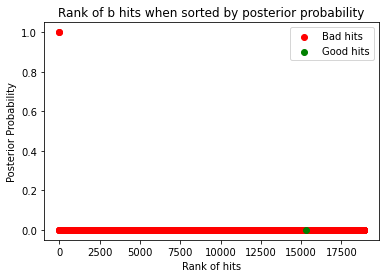

In [68]:
ion = 'b'
found = False
for i in range(0,50):
    target_cluster = b_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(b_bad_indexes, b_bad_cluster_prob, color = 'r', label = 'Bad hits')
plt.scatter(b_good_indexes, b_good_cluster_prob, color = 'g', label = 'Good hits')
plt.title('Rank of b hits when sorted by posterior probability')
plt.xlabel('Rank of hits')
plt.ylabel('Posterior Probability')
plt.legend()

Good hit found at: 0
Good hit found at: 1
Good hit found at: 2
Good hit found at: 3
Good hit found at: 4
Good hit found at: 5
Good hit found at: 6
Good hit found at: 7
Good hit found at: 8
Good hit found at: 9
Good hit found at: 10
Good hit found at: 11
Good hit found at: 12
Good hit found at: 13
Good hit found at: 14
Good hit found at: 15
Good hit found at: 16
Good hit found at: 17
Good hit found at: 18
Good hit found at: 19
Good hit found at: 20
Good hit found at: 21
Good hit found at: 22
Good hit found at: 23
Good hit found at: 24
Good hit found at: 25
Good hit found at: 26
Good hit found at: 27
Good hit found at: 28
Good hit found at: 29
Good hit found at: 30
Good hit found at: 31
Good hit found at: 32
Good hit found at: 33
Good hit found at: 34
Good hit found at: 35
Good hit found at: 36
Good hit found at: 37
Good hit found at: 38
Good hit found at: 39
Good hit found at: 40
Good hit found at: 41
Good hit found at: 42
Good hit found at: 43
Good hit found at: 44
Good hit found at: 4

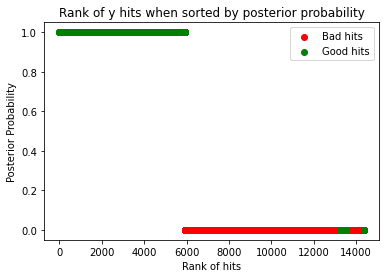

In [69]:
ion = 'y'
found = False
for i in range(0,50):
    target_cluster = y_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(y_bad_indexes, y_bad_cluster_prob, color = 'r', label = 'Bad hits')
plt.scatter(y_good_indexes, y_good_cluster_prob, color = 'g', label = 'Good hits')
plt.title('Rank of y hits when sorted by posterior probability')
plt.xlabel('Rank of hits')
plt.ylabel('Posterior Probability')
plt.legend()

In [70]:
print("Collecting Data...")
b_sorted_clusters = sorted(b_sorted_clusters, key=operator.attrgetter('score', 'prob', 'pid'), reverse = True)
y_sorted_clusters = sorted(y_sorted_clusters, key=operator.attrgetter('score', 'prob', 'pid'), reverse = True)
b_good_indexes = []
b_bad_indexes = []
b_good_scores = []
b_bad_scores = []
y_good_indexes = []
y_bad_indexes = []
y_good_scores = []
y_bad_scores = []
ion = 'b'
for i, cluster in enumerate(b_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        b_good_indexes.append(i)
        b_good_scores.append(cluster.score)
    else:
        b_bad_indexes.append(i)
        b_bad_scores.append(cluster.score)
ion = 'y'
for i, cluster in enumerate(y_sorted_clusters):
    assessment, _ = testing_utils.is_good_hit(cluster.seq, ion, correct_sequence)
    if assessment == True:
        y_good_indexes.append(i)
        y_good_scores.append(cluster.score)
    else:
        y_bad_indexes.append(i)
        y_bad_scores.append(cluster.score)
print('Done')

Done


No good hit found in the top 50 clusters


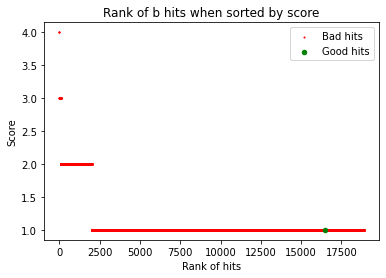

In [71]:
ion = 'b'
found = False
for i in range(0,134):
    target_cluster = b_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)    
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if found == False:
    print("No good hit found in the top 50 clusters")
plt.scatter(b_bad_indexes, b_bad_scores, color = 'r', label = 'Bad hits', s=1)
plt.scatter(b_good_indexes, b_good_scores, color = 'g', label = 'Good hits', s=20)
plt.title('Rank of b hits when sorted by score')
plt.xlabel('Rank of hits')
plt.ylabel('Score')
plt.legend()

Good hit found at: 1


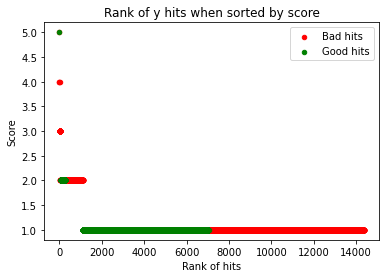

In [72]:
ion = 'y'
found = False
for i in range(0,10):
    target_cluster = y_sorted_clusters[i]
    assessment, _ = testing_utils.is_good_hit(target_cluster.seq, ion, correct_sequence)
    if assessment == True:
        print('Good hit found at:', i)
        found = True
if not found:
    print("No good hit found in the top 50 clusters")
plt.scatter(y_bad_indexes, y_bad_scores, color = 'r', label = 'Bad hits', s = 20)
plt.scatter(y_good_indexes, y_good_scores, color = 'g', label = 'Good hits', s = 20)
plt.title('Rank of y hits when sorted by score')
plt.xlabel('Rank of hits')
plt.ylabel('Score')
plt.legend()

# Distribution of size of seq vs weight

In [73]:
size_array = []
weight_array = []
prot_size_array = []
prot_weight_array = []
for seq in correct_sequences:
    size_array.append(len(seq))
    weight_array.append(gen_spectra.get_precursor(seq))

Text(0, 0.5, 'Weight of result')

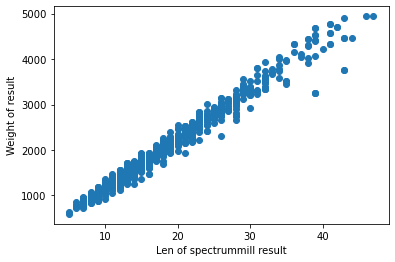

In [74]:
plt.scatter(size_array, weight_array)
plt.xlabel('Len of spectrummill result')
plt.ylabel('Weight of result')

Text(0, 0.5, 'Weight of Protein')

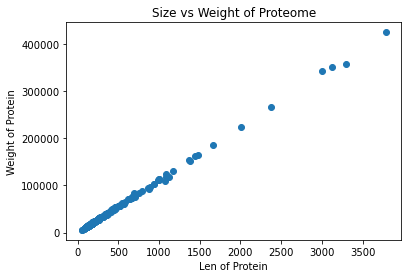

In [75]:
prot_size_array = []
prot_weight_array = []
for prot in db.proteins:
    target_prot = db.proteins[prot]
    if len(target_prot) != 0:
        target_prot = target_prot[0]
        seq = target_prot[1]
        prot_size_array.append(len(seq))
        prot_weight_array.append(gen_spectra.get_precursor(seq))
plt.scatter(prot_size_array, prot_weight_array)
plt.title('Size vs Weight of Proteome')
plt.xlabel('Len of Protein')
plt.ylabel('Weight of Protein')